## Table of Contents

### 1. Deploying Text Generation model
> #### 1.1 Install required libraries
> #### 1.2 Setup DL model using streamlit
> #### 1.3 Deploy DL model on Colab

---

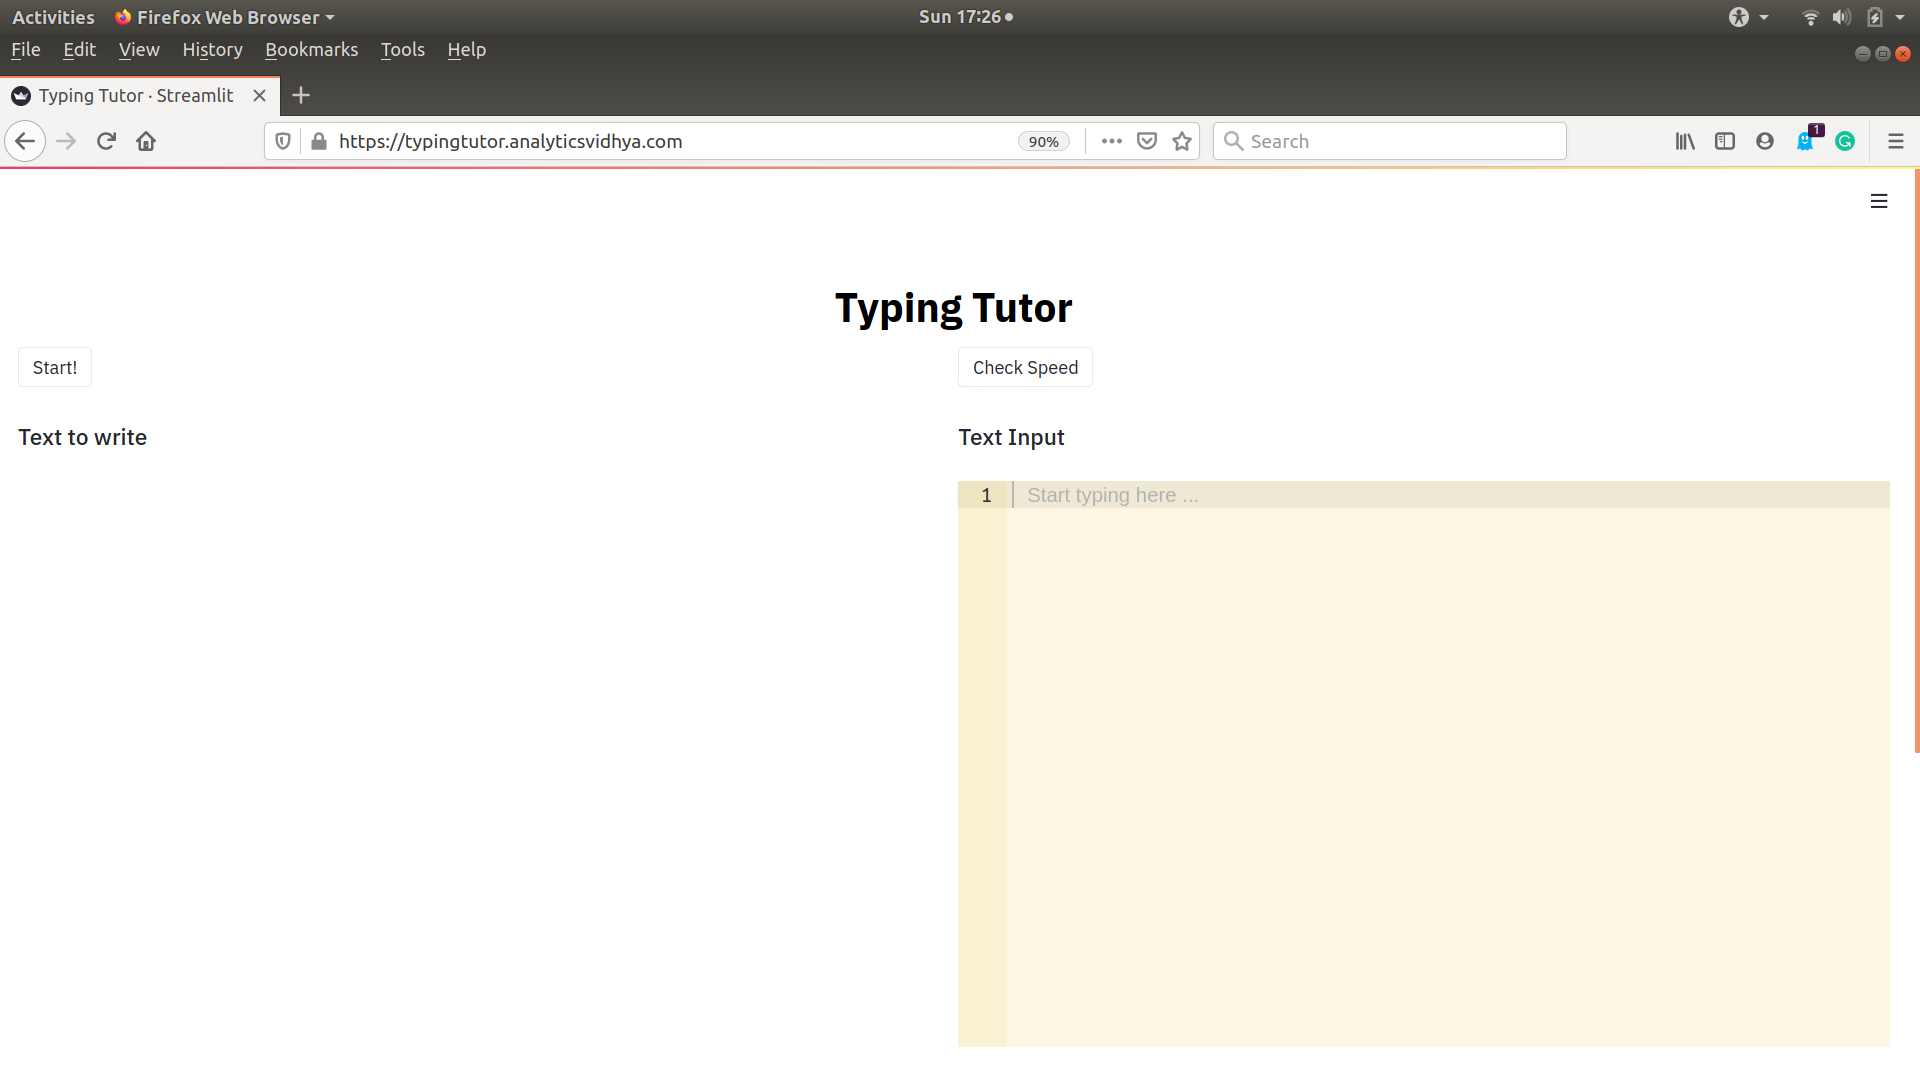

### Flow Chart of Typing Tutor

* Website starts → create instance of class TypingTutor → calls \__init__\()
  * Creates a unique session for the user 
  * Creates the front-end for the website
  * Initializes and loads DL model

* Click on “Start” button → calling on_start_click(), which 
  * Internally calls _code_gen() to generate code
  * Modifies session state variables (start_time, text, num_chars)
  * Updates the front-end accordingly


* Click on “Check Speed” button → calling on_eval_click(), which
  * Internally calls _get_perf() to calculate performance
  * Modifies session state variables (end_time, content)
  * Updates the front-end accordingly

---

### 1.1 Install required libraries

In [1]:
!pip install -q transformers
!pip install -q pyngrok
!pip install -q streamlit==0.70
!pip install -q streamlit_ace # streamlit component for coding window

     |████████████████████████████████| 1.9MB 5.8MB/s 
     |████████████████████████████████| 890kB 23.7MB/s 
     |████████████████████████████████| 3.2MB 28.8MB/s 
     |████████████████████████████████| 747kB 5.9MB/s 
     |████████████████████████████████| 7.4MB 4.7MB/s 
     |████████████████████████████████| 112kB 51.4MB/s 
     |████████████████████████████████| 163kB 50.8MB/s 
     |████████████████████████████████| 133kB 48.1MB/s 
     |████████████████████████████████| 7.5MB 34.6MB/s 
     |████████████████████████████████| 81kB 7.4MB/s 
     |████████████████████████████████| 4.6MB 53.9MB/s 
     |████████████████████████████████| 71kB 6.9MB/s 
     |████████████████████████████████| 71kB 573kB/s 
     |████████████████████████████████| 143kB 48.0MB/s 
     |████████████████████████████████| 122kB 42.0MB/s 
ERROR: requests 2.23.0 has requirement urllib3!=1.25.0,!=1.25.1,<1.26,>=1.21.1, but you'll have urllib3 1.26.3 which is incompatible.
ERROR: google-colab 1.0.0 has requi

**Remember to restart the runtime before running the code below**

### 1.2 Setup DL model using streamlit

In [1]:
#@title Define class SessionState file to maintain single session per login
%%writefile SessionState.py

# https://gist.github.com/FranzDiebold/898396a6be785d9b5ca6f3706ef9b0bc
"""Hack to add per-session state to Streamlit.

Works for Streamlit >= v0.65

Usage
-----

>>> import SessionState
>>>
>>> session_state = SessionState.get(user_name='', favorite_color='black')
>>> session_state.user_name
''
>>> session_state.user_name = 'Mary'
>>> session_state.favorite_color
'black'

Since you set user_name above, next time your script runs this will be the
result:
>>> session_state = get(user_name='', favorite_color='black')
>>> session_state.user_name
'Mary'

"""

import streamlit.report_thread as ReportThread
from streamlit.server.server import Server


class SessionState():
    """SessionState: Add per-session state to Streamlit."""
    def __init__(self, **kwargs):
        """A new SessionState object.

        Parameters
        ----------
        **kwargs : any
            Default values for the session state.

        Example
        -------
        >>> session_state = SessionState(user_name='', favorite_color='black')
        >>> session_state.user_name = 'Mary'
        ''
        >>> session_state.favorite_color
        'black'

        """
        for key, val in kwargs.items():
            setattr(self, key, val)


def get(**kwargs):
    """Gets a SessionState object for the current session.

    Creates a new object if necessary.

    Parameters
    ----------
    **kwargs : any
        Default values you want to add to the session state, if we're creating a
        new one.

    Example
    -------
    >>> session_state = get(user_name='', favorite_color='black')
    >>> session_state.user_name
    ''
    >>> session_state.user_name = 'Mary'
    >>> session_state.favorite_color
    'black'

    Since you set user_name above, next time your script runs this will be the
    result:
    >>> session_state = get(user_name='', favorite_color='black')
    >>> session_state.user_name
    'Mary'

    """
    # Hack to get the session object from Streamlit.

    session_id = ReportThread.get_report_ctx().session_id
    session_info = Server.get_current()._get_session_info(session_id)

    if session_info is None:
        raise RuntimeError('Could not get Streamlit session object.')

    this_session = session_info.session

    # Got the session object! Now let's attach some state into it.

    if not hasattr(this_session, '_custom_session_state'):
        this_session._custom_session_state = SessionState(**kwargs)

    return this_session._custom_session_state

Writing SessionState.py


In [2]:
%%writefile app.py

# import required modules and libraries
import time
import difflib
import logging  # to debug the website
import textwrap
import SessionState
import streamlit as st

from random import choice
from streamlit_ace import st_ace
from tokenizers import AddedToken
from transformers import AutoTokenizer, AutoModelWithLMHead

# define seed text
CONTEXTS = [
    "def fib",
    "def fact",
    "def sum_of_int",
    "def sum_of_fact",
    "def sum_of_square_error",
    "def get_val",
    "def convert_to_num",
    "def convolute",
    "def dict_sort",
]

# caching _load_model function so that it called only once
@st.cache(
    hash_funcs={
        st.delta_generator.DeltaGenerator: lambda x: None,
        AddedToken: lambda x: None,
        "_regex.Pattern": lambda x: None,
    },
    allow_output_mutation=True,
)
def _load_model():
    """Function to define pretrained text generation model
    """
    tokenizer = AutoTokenizer.from_pretrained(
        "congcongwang/distilgpt2_fine_tuned_coder"
    )
    model = AutoModelWithLMHead.from_pretrained(
        "congcongwang/distilgpt2_fine_tuned_coder"
    )
    model.eval()

    return tokenizer, model


class TypingTutor:
    """Class for text generation in streamlit
    """

    def __init__(self):
        """This function defines what happens when the website starts :-
            1. Creates session
            2. Creates the frontend 
            3. Loads DL model
        """

        ## step 1
        # define session
        self.session_state = SessionState.get(
            name="typingSession",
            start_time=0,
            end_time=0,
            num_chars=0,
            text="",
            content="",
        )

        ## step 2
        # create frontend
        st.set_page_config(page_title="Typing Tutor", layout="wide")

        # set title of the page
        st.markdown(
            "<h1 style='text-align: center; color: black;'>Typing Tutor</h1>",
            unsafe_allow_html=True,
        )

        # write hints for a new user
        placeholder = st.empty()
        with placeholder.beta_container():
            st.markdown("****")
            st.subheader("Steps to check your Typing speed")
            st.write(
                "1. When you are ready, click on the start button which will generate code for you to write on the left hand side. A point to note that the timer starts as soon as you click on the start button"
            )
            st.write(
                "2. Start writing the same code on the code window given on the right hand side. When you're done - press 'CTRL + ENTER' to save your code. **Remember to do this as this ensures that the code you have written is ready for submission**"
            )
            st.write(
                "3. Lastly, click on Check Speed button to check you writing accuracy and the writing speed. Good luck!"
            )
            st.markdown("****")

        # create two columns, one for code generated and other for code to write
        self.col1, self.col2 = st.beta_columns(2)

        with self.col1:
            self.start_button = st.button("Start!", key="start_button")
            st.subheader("Text to write")

        with self.col2:
            self.eval_button = st.button("Check Speed", key="eval_button")
            st.subheader("Text Input")
            st.write("")

            # define coding window
            self.session_state.content = st_ace(
                placeholder="Start typing here ...",
                language="python",
                theme="solarized_light",
                keybinding="sublime",
                font_size=20,
                tab_size=4,
                show_gutter=True,
                show_print_margin=True,
                wrap=True,
                readonly=False,
                auto_update=False,
                key="ace-editor",
            )

        ## step 3
        # load model and store it for use
        self.tokenizer, self.model = _load_model()

    def on_start_click(self):
        """This function defines what happens when the start button is clicked,
            1. Internally calls _code_gen() to generate code
            2. Modifies session state variables (start_time, text, num_chars)
            3. Updates the front-end accordingly
        """
        with self.col1:
            ## step 1
            # choose seed text
            context = choice(CONTEXTS)

            # get prediction
            self.session_state.text = self._code_gen(context)

            ## step 2
            # modify session state
            self.session_state.num_chars = len(self.session_state.text)
            self.session_state.start_time = time.time()

            ## step 3
            # write code using streamlit on the page
            st.code(textwrap.dedent(self.session_state.text))

        # logging
        logging.info(f"On start click, start time is {self.session_state.start_time}")
        logging.info(
            f"On start click, num_chars to type are {self.session_state.num_chars}"
        )

    def _code_gen(self, context):
        """Function for DL model inference
        """
        # preprocess seed text
        input_ids = self.tokenizer.encode(
            "<python> " + context, return_tensors="pt"
        )

        # generate output
        outputs = self.model.generate(
            input_ids=input_ids,
            max_length=256,
            temperature=0.7,
            num_beams=2,
            length_penalty=1.5,
        )

        # decode output to generate text
        text = self.tokenizer.decode(outputs[0], skip_special_tokens=True)

        return text

    def on_eval_click(self):
        """This function defines what happens when the eval button is clicked
            1. Internally calls _get_perf() to calculate performance
            2. Modifies session state variables (end_time, content)
            3. Updates the front-end accordingly
        """

        ## step 1
        # calculate typing speed and accuracy
        speed, accuracy = self._get_perf()

        ## step 3
        # write performance of the user using streamlit
        with self.col1:
            st.write("Time to write:", round(speed), "WPM")
            st.write("Accuracy:", round(accuracy * 100, 2), "%")

        # logging
        logging.info(f"On eval click, current time is {time.time()}")
        logging.info(f"On eval click, start time is {self.session_state.start_time}")
        logging.info(f"On eval click, end time is {self.session_state.end_time}")
        logging.info(f"On eval click, speed is {speed}")

    def _get_perf(self):
        """Function to get accuracy and typing speed
        """
        ## step 2
        # modify session state
        self.session_state.end_time = time.time() - self.session_state.start_time

        # get typing speed of the user
        speed = ((self.session_state.num_chars / self.session_state.end_time) / 5) * 60

        # get typing accuracy of the user
        accuracy = difflib.SequenceMatcher(
            None, self.session_state.text, self.session_state.content
        ).ratio()

        return speed, accuracy


if __name__ == "__main__":
    logging.info(f"Starting init")
    # create instance of the class
    tt = TypingTutor()
    logging.info(f"Done with init")

    # call appropriate method if start button is clicked
    if tt.start_button:
        logging.info(f"Start button clicked at {time.time()}")
        tt.on_start_click()
        logging.info(f"Done with Start button")

    # call appropriate method if eval button is clicked
    if tt.eval_button:
        logging.info(f"Eval button clicked at {time.time()}")
        tt.on_eval_click()
        logging.info(f"Done with Eval button")

Writing app.py


### 1.3 Deploy DL model on Colab

In [3]:
# run streamlit app
!streamlit run app.py --logger.level=info &>log.txt&

In [4]:
# make streamlit app available publicly
from pyngrok import ngrok

public_url = ngrok.connect('8501');

public_url

<NgrokTunnel: "http://920bad923cf5.ngrok.io" -> "http://localhost:8501">